<a href="https://colab.research.google.com/github/Untick/NetOptik/blob/Shironin-Igor-branch/Shironin%20Igor/%D1%81%D1%82%D0%B0%D0%B6%D0%B8%D1%80%D0%BE%D0%B2%D0%BA%D0%B0_%D1%81%D0%BE%D0%B7%D0%B4%D0%B0%D0%BD%D0%B8%D0%B5_%D0%B3%D0%B5%D0%BD%D0%B5%D1%80%D0%B0%D1%82%D0%BE%D1%80%D0%BE%D0%B2_%D0%B8%D0%B7%D0%BE%D0%B1%D1%80%D0%B0%D0%B6%D0%B5%D0%BD%D0%B8%D0%B9_%D0%B4%D0%BB%D1%8F_%D0%B2%D1%8B%D0%B1%D0%BE%D1%80%D0%BE%D0%BA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Библиотеки

In [ ]:
from PIL import Image, ImageEnhance       # Инструменты для работы с изображениями
import matplotlib.pyplot as plt           # Отрисовка графиков
import numpy as np                        # Работа с массивами
import random                             # Генерация случайных чисел
import math                               # Математические функции
# Для работы с файлами
import os
%matplotlib inline

# Загрузка изображений

In [ ]:
# Подключение модуля для загрузки данных из облака
import gdown
# открываем доступ к файлу и получаем ссылку
# https://drive.google.com/file/d/1NbT75UsIcdKlg9V4z1X2jxdTD_gzuBag/view?usp=sharing

f_1 = '1NbT75UsIcdKlg9V4z1X2jxdTD_gzuBag'# нужна только эта часть ссылки
gdown.download(f'https://drive.google.com/uc?id={f_1}', None, quiet=True)
# Разархивация датасета в директорию '/content/Foto/'
!unzip -qo "датасет атрибуты 94 файла.zip" -d /content/Foto
# Папка с папками картинок
IMAGE_PATH = '/content/Foto/датасет атрибуты/'


# Получение списка файлов - files и списка путей к ним -files_paths

In [ ]:
# Получаем список файлов в директории
files = os.listdir(IMAGE_PATH)
# Составляем список путей к файлам
files_paths = [os.path.join(IMAGE_PATH, file) for file in files]

# получение списка файлов data_img c размерностью 640x640

In [ ]:
data_img = []
for i in range(len(files_paths)):
  img_old  = Image.open( files_paths[i])
  img = img_old.resize((640,640))
  data_img +=[img]

# разделение на выборки

In [ ]:
a = int(len(data_img)/100*10) # 10 % от колисества изображений
a

9

In [ ]:
data_train = data_img[:len(data_img)-2*a]
data_val = data_img[len(data_img)-2*a:len(data_img)-a]
data_test = data_img[len(data_img)-a:]
print(len(data_train))
print(len(data_val))
print(len(data_test))

76
9
9


In [ ]:
# метки
data_train_mark = files[:len(data_img)-2*a]
data_val_mark = files[len(data_img)-2*a:len(data_img)-a]
data_test_mark = files[len(data_img)-a:]
print(len(data_train_mark))
print(len(data_val_mark))
print(len(data_test_mark))

76
9
9


# Создание генератора

In [ ]:
def show_image_pair(img1, img2):
    # Cоздание полотна для рисования двух изображений
    fig, axs = plt.subplots(1, 2, figsize=(4, 2))
    # Исходное изображение
    axs[0].imshow(img1)
    axs[0].axis('off')
    # Модифицированное изображение
    axs[1].imshow(img2)
    axs[1].axis('off')
    # Вывод изображений
    plt.show()

In [ ]:
# подрезка изображения чтобы небыло черных углов
def rotated_rect(w,                       # Ширина изображения
                 h,                       # Высота изображения
                 angle                    # Угол поворота в градусах
                 ):
    angle = math.radians(angle)
    width_is_longer = w >= h
    side_long, side_short = (w,h) if width_is_longer else (h,w)

    sin_a, cos_a = abs(math.sin(angle)), abs(math.cos(angle))

    if side_short <= 2.*sin_a*cos_a*side_long or abs(sin_a-cos_a) < 1e-10:
        x = 0.5 * side_short
        wr, hr = (x/sin_a, x/cos_a) if width_is_longer else (x/cos_a, x/sin_a)
    else:
        cos_2a = cos_a*cos_a - sin_a*sin_a
        wr, hr = (w*cos_a - h*sin_a)/cos_2a, (h*cos_a - w*sin_a)/cos_2a

    return wr, hr # Ширина и Высота прямоугольника обрезки

In [ ]:
 # функция поворота на случайный угол (в градусах) с учетом необходимой обрезки
 # + востановление размеров
def random_rot(x,                         # Подаваемое изображение
               ang                        # Максимальный угол поворота
               ):
    # Случайное значение угла в диапазоне [-ang, ang]
  a = random.uniform(-1., 1.) * ang
    # Вращение картинки с расширением рамки
  r = x.rotate(a, expand=True)
    # Вычисление размеров прямоугольника обрезки максимальной площади
    # для размеров исходной картинки и угла поворота в градусах
  crop_w, crop_h = rotated_rect(x.width, x.height, a)
    # Обрезка повернутого изображения и возврат результата
  w, h = r.size
  y = r.crop(((w - crop_w)*0.5, (h - crop_h)*0.5,
                   (w + crop_w)*0.5, (h + crop_h)*0.5))
  y = y.resize((x.width,x.height))
  return y

In [ ]:
def random_contrast(x,                    # Подаваемое изображение
                    level                 # Максимальное отклонение коэффициента контраста от нормы - число от 0. до 1.
                    ):
    enh = ImageEnhance.Contrast(x)        # Создание экземпляра класса Contrast
    factor = random.uniform(1. - level,
                            1. + level)   # Cлучайный коэффициент контраста из указанного интервала
    return enh.enhance(factor)            # Изменение коэффициента контраста

In [ ]:
def random_brightness(x,                  # Подаваемое изображение
                      level               # Максимальное отклонение коэффициента яркости от нормы - число от 0. до 1.
                      ):
    enh = ImageEnhance.Brightness(x)      # Создание экземпляра класса Brightness
    factor = random.uniform(1. - level,
                            1. + level)   # Cлучайный коэффициент контраста из указанного интервала
    return enh.enhance(factor)

In [ ]:
ang = 15
level = 0.5

In [ ]:
def img_aug(img):
# Последовательное применение случайных изменений исходного изображения
 img = random_rot(img, ang)
 img = random_brightness(img, level)
 img = random_contrast(img, level)
 return img

In [ ]:
# функция для получения списка из n аугментированых изображений + родное
# со списком одинаковых меток например '50.jpg'

def aug_list(img, n, mark):
  img_list = [img]
  a_list = [mark]
  for i in range(n):
    img_list += [img_aug(img)]
    a_list+=[a]
  return img_list , a_list

In [ ]:
def aug_list_n (img_list,mark_list, n) :
  data_x = []
  data_y = []
  for i in range(len(img_list )):
    list_img ,list_a = aug_list(data_img[i],n-1,mark_list[i])
    for j in range(len(list_img )):
      data_x += [list_img[j]]
      data_y += [list_a[j]]
  return data_x, data_y


In [ ]:
n = 5
data_train_n, data_train_mark_n = aug_list_n (data_train, data_train_mark , n)
print(len(data_train_mark_n))
print(len(data_train_n))

380
380


In [ ]:
data_val_n, data_val_mark_n = aug_list_n (data_val, data_val_mark , n)
print(len(data_val_mark_n))
print(len(data_val_n))

45
45


In [ ]:
data_test_n, data_test_mark_n = aug_list_n (data_test, data_test_mark , n)
print(len(data_test_mark_n))
print(len(data_test_n))

45
45


(640, 640)


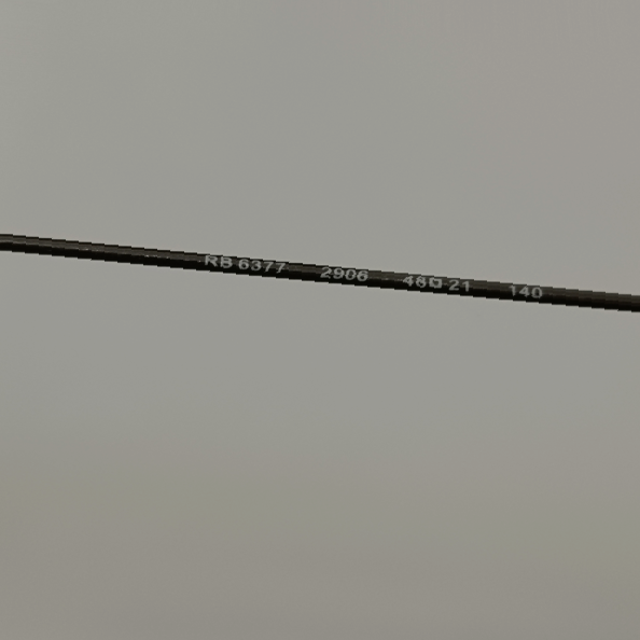

In [ ]:
img  = data_train_n[21]
print(img.size)
img

# Сохранение измененных изображений на Google Drive:

In [ ]:
# Сохранение измененных изображений на Google Drive:
for i in range(len(data_test_n)):
  resized_img = data_test_n[i]
  resized_img.save(f'/content/drive/MyDrive/стажировка/data/test/img/{i}.jpg')
for i in range(len(data_train_n)):
  resized_img = data_train_n[i]
  resized_img.save(f'/content/drive/MyDrive/стажировка/data/train/img/{i}.jpg')
for i in range(len(data_val_n)):
  resized_img = data_val_n[i]
  resized_img.save(f'/content/drive/MyDrive/стажировка/data/val/img/{i}.jpg')
